# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

from pandas.api.types import CategoricalDtype

import seaborn as sns

sns.set_palette("Set2")

## 
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Utils

In [2]:
def plot_coefficients(coefs, n_highlight):
    thisplot, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    # takes most important coeffs in abs value
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    thisplot.figure.savefig("my_plot.png")

# Preprocessing

In [3]:
data = pd.read_csv("processed/BLCA_data_preprocessed.csv")#, low_memory=False)

In [4]:
modality_list = ["clinical",
"gex",
"rppa",
"mirna",
"mutation",
"meth",
"cnv"]

In [5]:
omic = 2 # 0 is clinical
modalities_to_keep = modality_list[omic]
modality_mask = [col for col in data.columns if col.rsplit("_")[0] in modalities_to_keep]

In [6]:
X = data[modality_mask]
y = data[['OS', 'OS_days']].rename(columns={'OS_days' : 'time'}).rename(columns={'OS' : 'event'})
y['event'] = y['event'].astype(bool)
y = np.array(y.to_records(index=False))

In [7]:
# transform objects into categories
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

In [8]:
Xt = OneHotEncoder().fit_transform(X).fillna(0)
Xt.round(2).head()

,rppa_X1433EPSILON,rppa_X4EBP1,rppa_X4EBP1_pS65,rppa_X4EBP1_pT37T46,rppa_X53BP1,rppa_ACC_pS79,rppa_ACC1,rppa_AKT,rppa_AKT_pS473,rppa_AKT_pT308,...,rppa_X1433BETA,rppa_X1433ZETA,rppa_ACVRL1,rppa_DIRAS3,rppa_ANNEXIN1,rppa_PREX1,rppa_ERCC1,rppa_MSH2,rppa_MSH6,rppa_SMAC
0,-0.80,0.68,0.20,0.83,1.02,-0.43,1.44,1.10,-0.80,0.08,...,-0.62,1.49,0.03,-2.88,-0.18,-0.37,-0.83,-1.06,-0.52,0.48
1,-0.60,1.29,0.53,1.22,0.13,-0.67,1.78,-2.26,-1.78,0.09,...,-0.36,2.45,0.06,-2.95,2.22,0.38,-1.03,-0.67,-0.60,0.40
2,-0.77,0.63,0.07,0.83,1.19,1.01,2.84,0.79,-1.14,0.07,...,-0.67,1.69,-0.60,-3.23,1.16,-0.27,-1.04,-0.53,0.06,0.55
3,-0.61,1.35,0.49,1.42,2.25,-0.32,1.66,1.06,-1.84,-0.80,...,-0.60,1.39,-0.54,-3.08,1.36,0.75,-0.41,-0.23,0.25,0.36
4,-0.63,1.70,0.88,2.17,1.86,0.24,2.27,1.02,-1.48,-0.45,...,-0.57,1.50,-0.32,-2.98,1.55,0.09,-0.72,-0.29,0.25,0.20


# Ridge - L2 Models to estabilish ranking

In [9]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

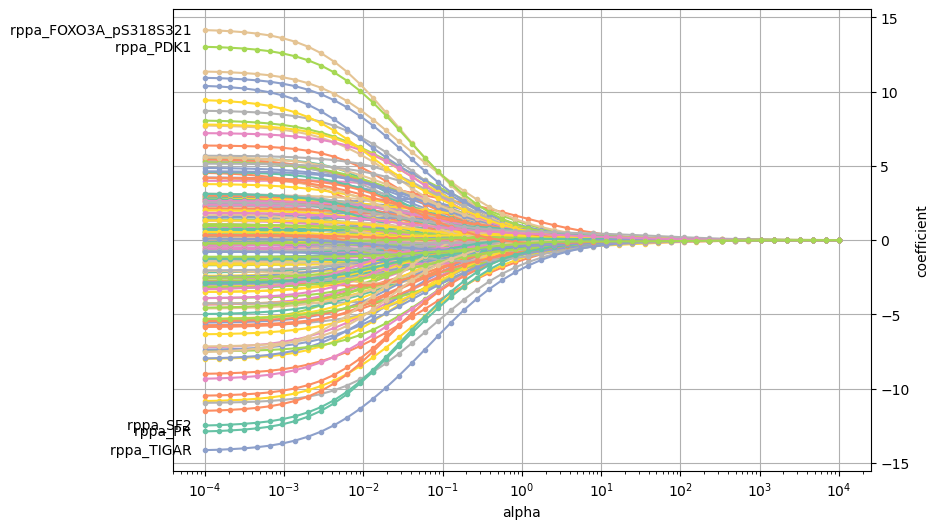

In [10]:
plot_coefficients(coefficients, n_highlight=5)

In [11]:
coefficients

alpha,0.00010,0.00015,0.00021,0.00031,0.00045,0.00066,0.00095,0.00139,0.00202,0.00295,...,339.32218,494.17134,719.68567,1048.11313,1526.41797,2222.99648,3237.45754,4714.86636,6866.48845,10000.00000
rppa_X1433EPSILON,5.498266,5.493981,5.487477,5.477484,5.461928,5.437426,5.398560,5.336987,5.240723,5.094347,...,-0.002519,-0.001884,-0.001349,-0.000926,-0.000612,-0.000391,-0.000244,-0.000150,-0.000092,-0.000056
rppa_X4EBP1,-0.111765,-0.113394,-0.115727,-0.119044,-0.123711,-0.130182,-0.138975,-0.150597,-0.165386,-0.183258,...,0.004421,0.003172,0.002195,0.001472,0.000965,0.000625,0.000404,0.000263,0.000173,0.000115
rppa_X4EBP1_pS65,4.217675,4.212873,4.205925,4.195898,4.181487,4.160885,4.131651,4.090569,4.033561,3.955696,...,-0.011890,-0.008663,-0.006187,-0.004350,-0.003023,-0.002083,-0.001428,-0.000977,-0.000667,-0.000456
rppa_X4EBP1_pT37T46,-2.759812,-2.756637,-2.752038,-2.745396,-2.735836,-2.722150,-2.702702,-2.675356,-2.637454,-2.585904,...,-0.033549,-0.026136,-0.020032,-0.015113,-0.011234,-0.008235,-0.005960,-0.004266,-0.003024,-0.002126
rppa_X53BP1,2.054497,2.052100,2.048631,2.043626,2.036443,2.026210,2.011802,1.991868,1.964972,1.929876,...,0.009246,0.006364,0.004268,0.002755,0.001694,0.000983,0.000534,0.000268,0.000122,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rppa_PREX1,-2.881958,-2.874946,-2.864836,-2.850323,-2.829619,-2.800350,-2.759487,-2.703401,-2.628118,-2.529840,...,0.004046,0.002932,0.002283,0.001867,0.001552,0.001279,0.001030,0.000806,0.000613,0.000455
rppa_ERCC1,4.192887,4.188268,4.181509,4.171606,4.157084,4.135794,4.104658,4.059419,3.994493,3.903072,...,0.005323,0.004960,0.004290,0.003503,0.002731,0.002053,0.001502,0.001077,0.000761,0.000533
rppa_MSH2,0.093114,0.090225,0.086067,0.080107,0.071624,0.059661,0.043000,0.020171,-0.010467,-0.050534,...,0.008936,0.005821,0.003634,0.002164,0.001221,0.000646,0.000315,0.000136,0.000046,0.000006
rppa_MSH6,1.833079,1.829545,1.824456,1.817163,1.806786,1.792168,1.771857,1.744161,1.707318,1.659812,...,0.025332,0.018457,0.013181,0.009222,0.006331,0.004279,0.002862,0.001904,0.001267,0.000845


# Lasso - Study coefficients behaviour changing alpha

In [12]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, verbose=True)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0, verbose=True)

In [13]:
cox_lasso.get_params()

{'alpha_min_ratio': 0.01,
 'alphas': None,
 'copy_X': True,
 'fit_baseline_model': False,
 'l1_ratio': 1.0,
 'max_iter': 100000,
 'n_alphas': 100,
 'normalize': False,
 'penalty_factor': None,
 'tol': 1e-07,
 'verbose': True}

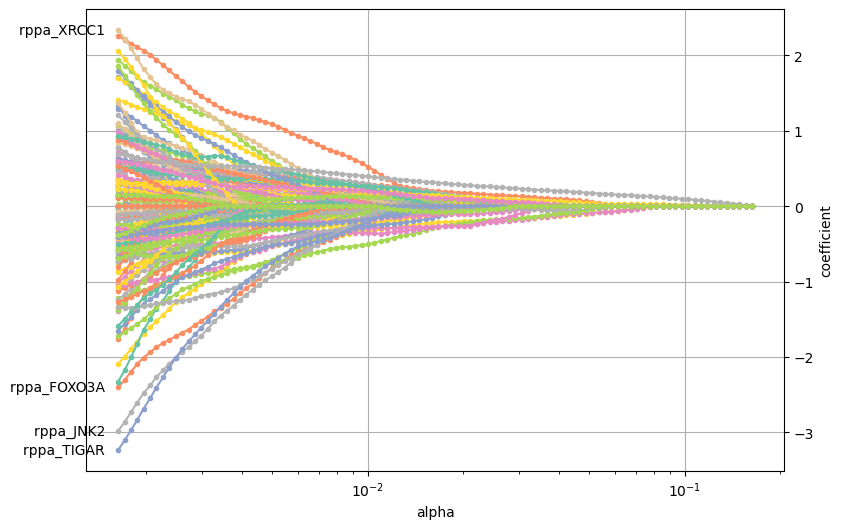

In [14]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=4)

# Elastic-Net - a caso

In [15]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

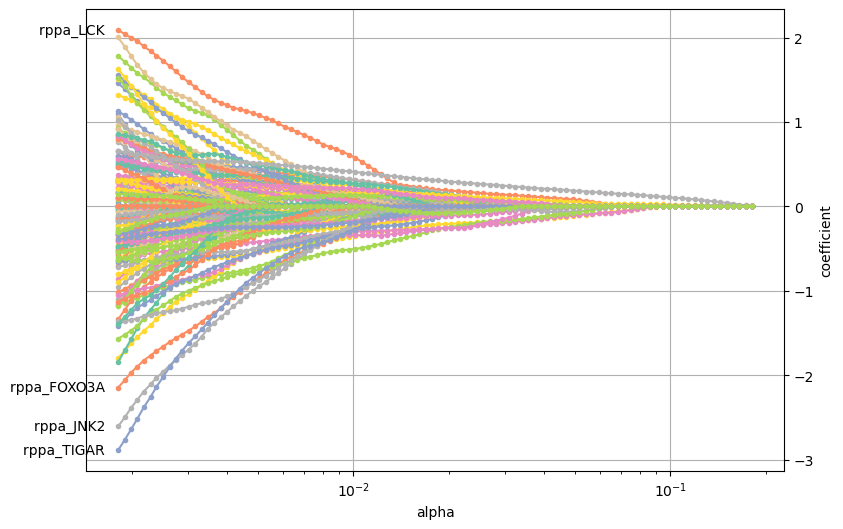

In [16]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=4)

# Omic score

In [17]:
coxnet_pipe = make_pipeline(StandardScaler(), 
                            CoxnetSurvivalAnalysis(l1_ratio=0.9, 
                                                   alpha_min_ratio=0.01, 
                                                   max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [18]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] 
                                                   for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [19]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016675,0.002238,0.012438,0.007157,[0.15472772021776104],{'coxnetsurvivalanalysis__alphas': [0.15472772...,0.546366,0.500436,0.470191,0.500000,0.500000,0.503399,0.024416,88
1,0.012839,0.000729,0.005172,0.000348,[0.14769510653666787],{'coxnetsurvivalanalysis__alphas': [0.14769510...,0.546366,0.505667,0.471316,0.500000,0.500000,0.504670,0.024065,86
2,0.011797,0.000053,0.004749,0.000058,[0.14098213600108148],{'coxnetsurvivalanalysis__alphas': [0.14098213...,0.546366,0.513514,0.470191,0.589129,0.650502,0.553940,0.062077,69
3,0.012654,0.000558,0.006032,0.001141,[0.1345742803367211],{'coxnetsurvivalanalysis__alphas': [0.13457428...,0.555556,0.514385,0.471316,0.600320,0.650502,0.558416,0.062879,64
4,0.012729,0.000858,0.005128,0.000254,[0.12845767160179414],{'coxnetsurvivalanalysis__alphas': [0.12845767...,0.563074,0.509154,0.470191,0.617906,0.650502,0.562165,0.066604,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.688923,1.126451,0.001443,0.001776,[0.0018637008677846434],{'coxnetsurvivalanalysis__alphas': [0.00186370...,0.500000,0.399303,0.525309,0.500000,0.500000,0.484922,0.043918,96
96,1.300971,1.173969,0.001333,0.001651,[0.0017789927870231522],{'coxnetsurvivalanalysis__alphas': [0.00177899...,0.500000,0.399303,0.501687,0.500000,0.500000,0.480198,0.040453,99
97,1.604421,1.324074,0.002321,0.001942,[0.001698134819265485],{'coxnetsurvivalanalysis__alphas': [0.00169813...,0.421053,0.394071,0.541057,0.500000,0.500000,0.471236,0.054777,100
98,0.872265,0.482344,0.000000,0.000000,[0.0016209519709335912],{'coxnetsurvivalanalysis__alphas': [0.00162095...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,89


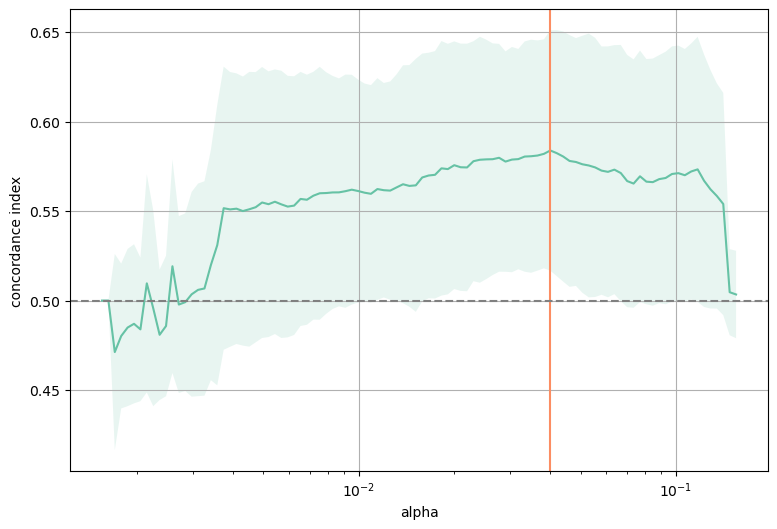

In [44]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 30


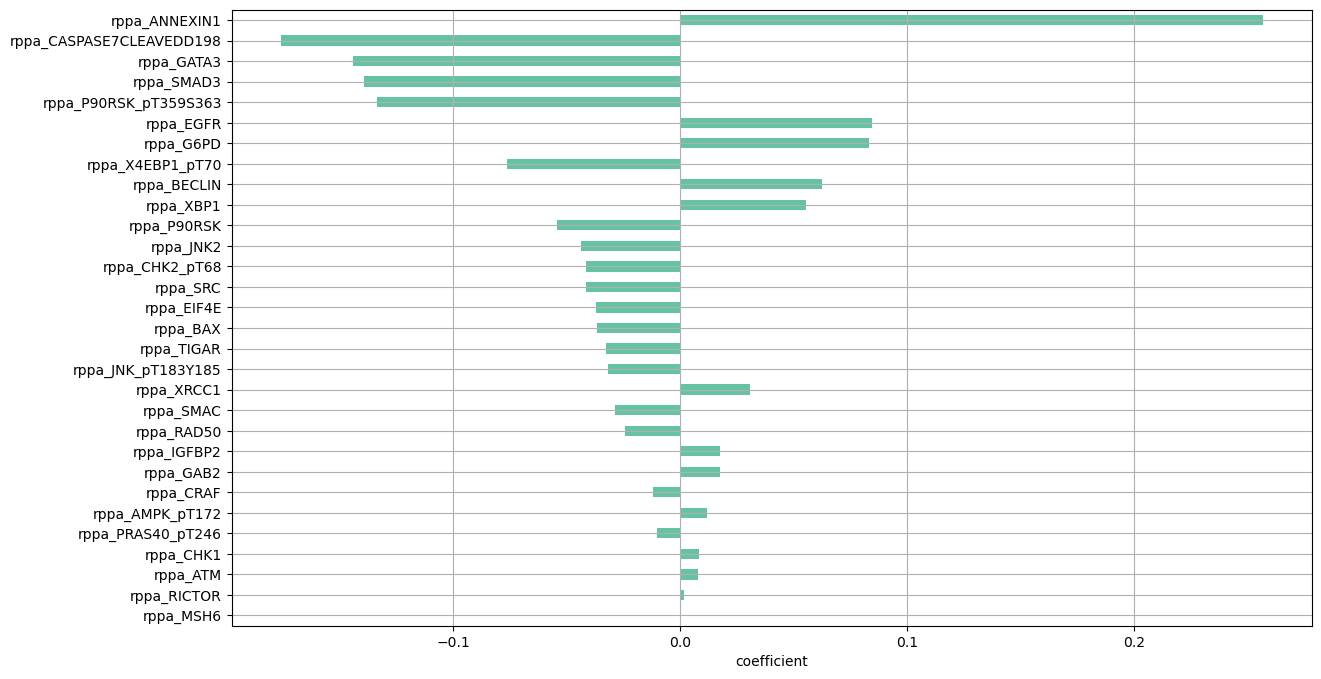

In [40]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

thisplot, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
#thisplot.tight_layout()

thisplot.subplots_adjust(left=-0.9)

thisplot.savefig("my_plot.png")
#thisplot.figure.savefig("p.png")

In [39]:
thisplot.tight_layout()
thisplot.figure.savefig("images/rppa_interpret_plot.png")

In [43]:
best_coefs.shape

(189, 1)

In [25]:
# score -> surrogate for knowledge-based priority order
np.absolute(best_coefs["coefficient"].to_numpy()).mean()

0.008996837958983595

# Best Alphas

Before we can use GridSearchCV, we need to determine the set of alphas which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. 
Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. 
Note that we are using StandardScaler to account for scale differences among features and allow direct comparison of coefficients.

In [26]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [27]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

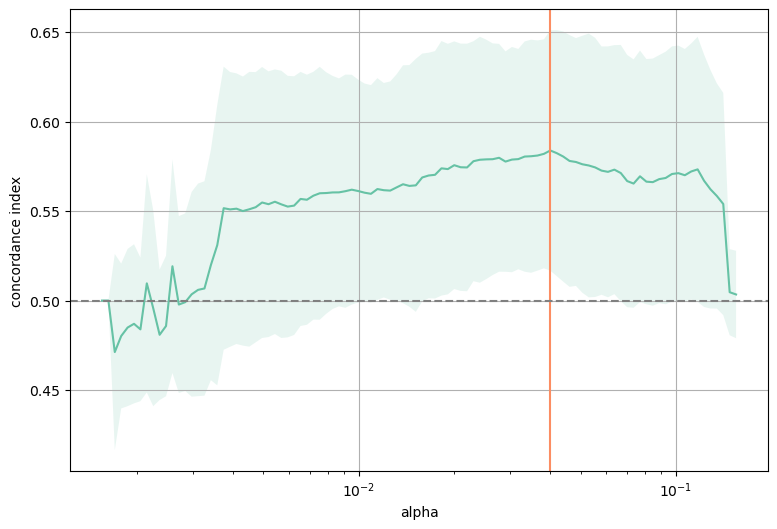

In [28]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 30


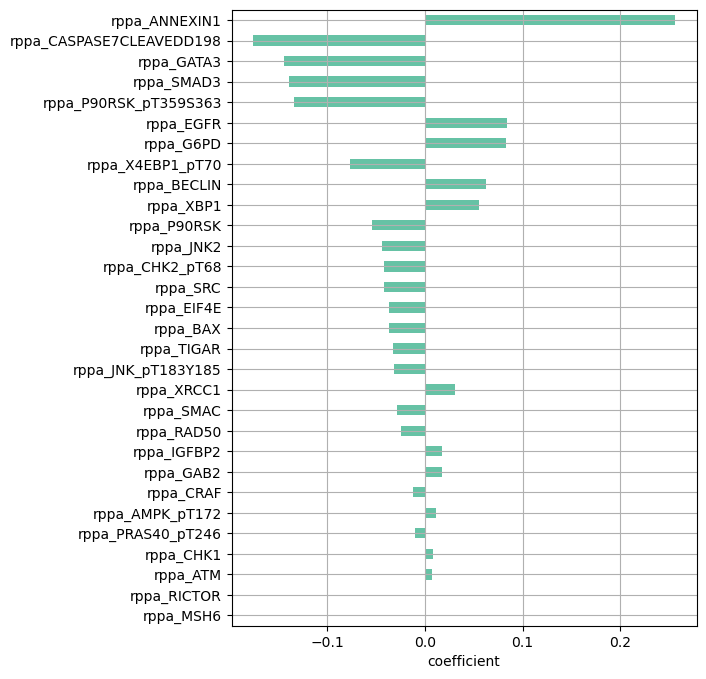

In [29]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [30]:
# fit baseline important!!!
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(
    l1_ratio=0.9, 
    fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.0401522180139775],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [31]:
Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int)

KeyError: 'clinical_ajcc_pathologic_tumor_stage=Stage IV'

In [ ]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
thisplot, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, (-Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int).astype(bool)).astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label: 
        print("label = ", label)
        print("len = ", len(legend_handles))
        name =  "Another stage" if label == 1 else "Stage IV"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)
thisplot.figure.savefig("my_plot.png")

In [ ]:
plot_coefficients(coefficients, n_highlight=5)

In [ ]:
(-Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage IV"].astype(int).astype(bool)).astype(int)

In [ ]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
thisplot, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "clinical_ajcc_pathologic_tumor_stage=Stage II"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label:
        print("label = ", label)
        print("len = ", len(legend_handles))
        name = "Stage II" if label == 1 else "Another stage"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)
thisplot.figure.savefig("survstage2.png")

In [ ]:

min_value = Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].min()
max_value = Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].max()

surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
fig, ax = plt.subplots(figsize=(9, 6))
cmap = colormaps['viridis']
for fn, label in zip(surv_fns, Xt.loc[:, "clinical_age_at_initial_pathologic_diagnosis"].astype(int)):
    normalized_color = (label - min_value) / (max_value - min_value)
    (line,) = ax.step(time_points, fn(time_points), where="post", color = cmap(normalized_color), alpha=0.5)
    if len(legend_handles) <= label and ((label >= max_value - 2 ) or (label <= min_value + 5)):
        name = label
        legend_labels.append(name)
        legend_handles.append(line)

norm = plt.Normalize(vmin=min_value, vmax=max_value)  # Normalize the data range to [0, 1]
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

#ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.set_title("Survival function by age")
ax.grid(True)
fig.figure.savefig("surv_age.png")

In [ ]:
plot_coefficients(coefficients, n_highlight=5)

# Crossval

In [ ]:
# Initialize the 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
coefficients_df = pd.DataFrame()
alphas = []

## alpha -> best alpha on average -> refit best alpha each fold and take coefficients
## mean mean absolute error  of non-censored !!!!!!!

for i, (train_index, test_index) in enumerate(kf.split(Xt)):
    X_train = Xt.iloc[train_index]
    X_test = Xt.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", FitFailedWarning)
    coxnet_pipe.fit(X_train, y_train)
    estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
    ).fit(X_train, y_train)

    #cv_results = pd.DataFrame(gcv.cv_results_)
    best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
    best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])
    
    alphas.append(best_model)
    
    if coefficients_df.empty:
        coefficients_df = best_coefs
        coefficients_df.rename(columns={'coefficient': 'coeff_0'}, inplace=True)
    else:
        coefficients_df[f"coeff_{i}"] = best_coefs

# Convert the list of coefficients into a DataFrame for easy visualization
#coefficients_df = pd.DataFrame(coefficients_list)
#print(coefficients_df)

In [ ]:
alphas

In [ ]:
coefficients_df

In [ ]:
coefficents_cv = pd.DataFrame(coefficients_df.mean(axis=1))
coefficents_cv.rename(columns={ 0 : 'coeff_CV'}, inplace=True)
coefficents_cv

# get residual

In [ ]:
coefficents_cv['coeff_CV'].to_dict()

In [ ]:
coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=1)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

In [ ]:
best_model.coef_

In [ ]:
best_model.coef_ = coefficents_cv.to_numpy()
best_model.coef_

In [ ]:
best_model.predict(Xt)[:10]

In [ ]:
y2 = y

In [ ]:
y2['time'] =  y['time'] - best_model.predict(Xt)

In [ ]:
y[:10]

In [ ]:
y2[:10]

## Plots random

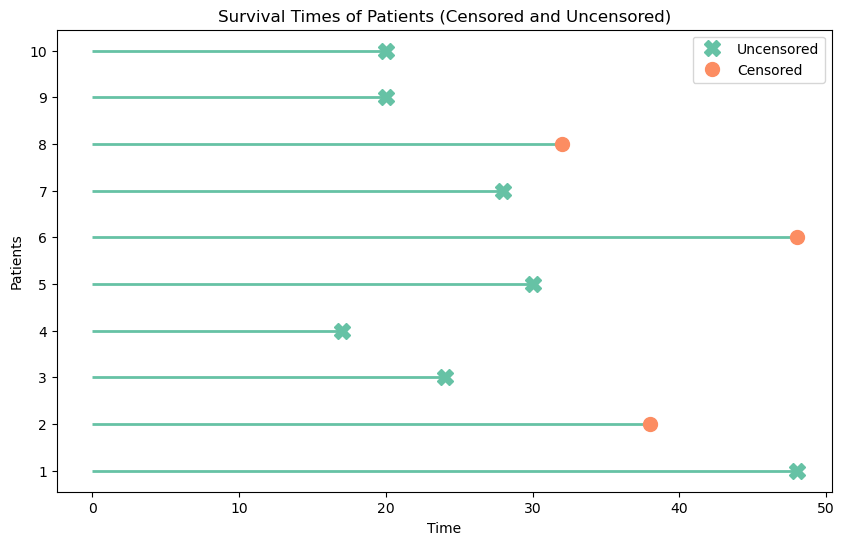

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
np.random.seed(42)
n_patients = 10
max_time = 50
col1 = sns.color_palette("Set2")[0]
col2 = sns.color_palette("Set2")[1]
# Generating random survival times and censoring status
survival_times = np.random.randint(10, max_time, n_patients)
censored = np.random.choice([True, False], n_patients)

plt.figure(figsize=(10, 6))

first_c = False
first_uc = False

for i in range(n_patients):
    # Plotting a line for each patient
    plt.hlines(y=i+1, xmin=0, xmax=survival_times[i], lw=2)
    # Marking censored patients with a "o" and uncensored with an "x"
   
    if censored[i]:
        if first_c != True:
            plt.plot(survival_times[i], i+1,'o', color=col2, markersize=10, label="Censored")
            first_c = True
        else:
            plt.plot(survival_times[i], i+1,'o', color=col2, markersize=10)
    else:
        if first_uc != True:
            plt.plot(survival_times[i], i+1,'X', color=col1, markersize=12, label="Uncensored") 
            first_uc = True
        else:
            plt.plot(survival_times[i], i+1,'X', color=col1, markersize=12) 

plt.xlabel('Time')
plt.ylabel('Patients')
plt.title('Survival Times of Patients (Censored and Uncensored)')
plt.yticks(range(1, n_patients+1))
plt.legend()
#plt.show()
plt.savefig("censored.png")